In [1]:
import sys
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple

from scipy.stats import norm
import pickle as pk

from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

# Load the Mnist Dataset

In [2]:
DataPath = r"D:\PatternRecognition_Data"

train_data = datasets.MNIST(DataPath, train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)
transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
])

batch_size = 32
trainset = datasets.MNIST(root=DataPath, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST(root=DataPath, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [4]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 28, 28])

# Autoencoder Network Implementation
Implement an Autoencoder that encodes the MNIST dataset to a latent dimension of size
m < 784. Use Tranposed Convolutions and/or Unpooling to solve this exercise. 

In [5]:
class Autoencoder(nn.Module):
  def __init__(self, latent_width):
    # Initialize as subclass of nn.Module inheriting all its functions
    super(Autoencoder, self).__init__()
    encode = [nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
              nn.LeakyReLU(),
              nn.BatchNorm2d(32)]
    decode = [nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(16),
              nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=0),
              nn.LeakyReLU(),
              nn.BatchNorm2d(1)]
    self.encoder = nn.Sequential(*encode)
    self.encoder_end = nn.Linear(32 * 7 * 7, latent_width)
    self.decoder_start = nn.Linear(latent_width, 32 * 7 * 7)
    self.decoder = nn.Sequential(*decode)
                                           

  def forward(self, x):
    z = self.encoder(x)
    z = self.encoder_end(z.reshape([z.shape[0],-1]))
    y = self.decoder_start(z)
    y = self.decoder(y.reshape([y.shape[0],32,7,7]))
    return y

In [6]:
def train_AE(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
    """
    Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
    """
  
    use_test = False
    if isinstance(data, DataLoader):
        train_loader = data
    elif isinstance(data, tuple):
        if len(data) == 2:
            train_loader, test_loader = data
            if not isinstance(train_loader, DataLoader):
                raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
            if not isinstance(test_loader, DataLoader):
                raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
            use_test = True
        else:
            raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
    criterion = nn.MSELoss()
    model.train()
    losses = []
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            if cuda:
                x, y = x.cuda(), y.cuda()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if batch_idx % 50 == 0:
                sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} Loss: {loss.item():.6f}')
    return losses

In [7]:
autoenc_model = Autoencoder(latent_width=100)
summary(autoenc_model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
         LeakyReLU-2           [-1, 16, 14, 14]               0
       BatchNorm2d-3           [-1, 16, 14, 14]              32
            Conv2d-4             [-1, 32, 7, 7]           4,640
         LeakyReLU-5             [-1, 32, 7, 7]               0
       BatchNorm2d-6             [-1, 32, 7, 7]              64
            Linear-7                  [-1, 100]         156,900
            Linear-8                 [-1, 1568]         158,368
   ConvTranspose2d-9           [-1, 16, 14, 14]           2,064
        LeakyReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
  ConvTranspose2d-12            [-1, 1, 28, 28]              65
        LeakyReLU-13            [-1, 1, 28, 28]               0
      BatchNorm2d-14            [-1, 1,

## Train the Autoencoder and visualize a few reconstructed Images
Train the Autoencoder and plot the reconstruction training loss. Plot 5 digits (of your choice) before
and after reconstruction. Do this for two different latent dimension sizes.

### Train with latent space size 100:

In [8]:
autoenc_model_100 = Autoencoder(latent_width=100)
autoenc_model_100 = autoenc_model_100.cuda()
autoenc_optim_100 = optim.Adam(autoenc_model_100.parameters(), lr=1e-5)
autoenc_losses_100 = train_AE(autoenc_model_100, autoenc_optim_100, (train_loader, test_loader), max_epochs=10)

Epoch: 9/10 Step: 1850/1875 Loss: 0.145796

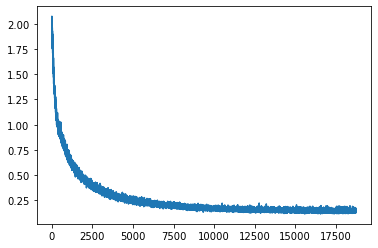

In [9]:
plt.plot(autoenc_losses_100)

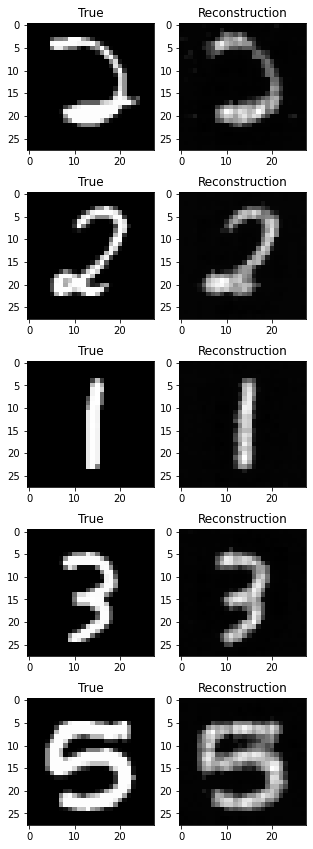

In [10]:
x, y = next(iter(train_loader))
# img_block = autoenc_model.decoder(torch.rand(32,16,7,7))
img_block = autoenc_model_100(x[:5].cuda())

fig = plt.figure(figsize=(5, 15))
columns = 2
rows = 5
counter = 0
for x, img in zip(x[:5],img_block):
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(x[0], cmap="gray")
    counter += 1
    plt.title("True")
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Reconstruction")
    counter += 1
plt.show()

### Train with latent space size 10:

In [11]:
autoenc_model_10 = Autoencoder(latent_width=10)
autoenc_model_10 = autoenc_model_10.cuda()
autoenc_optim_10 = optim.Adam(autoenc_model_10.parameters(), lr=1e-5)
autoenc_losses_10 = train_AE(autoenc_model_10, autoenc_optim_10, (train_loader, test_loader), max_epochs=10)

Epoch: 9/10 Step: 1850/1875 Loss: 0.397266

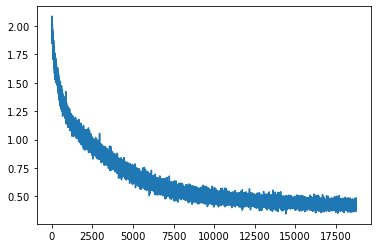

In [12]:
plt.plot(autoenc_losses_10)

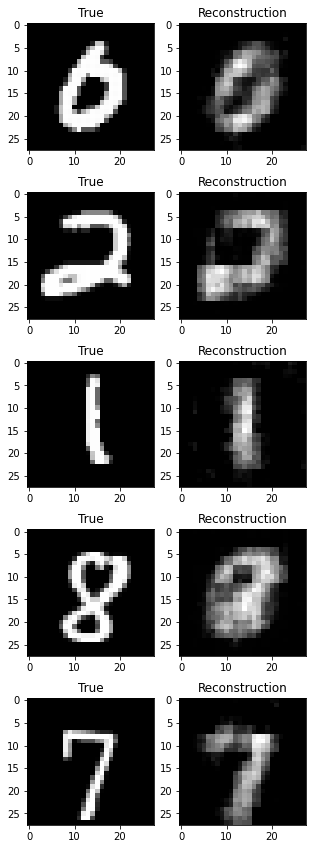

In [13]:
x, y = next(iter(train_loader))
# img_block = autoenc_model.decoder(torch.rand(32,16,7,7))
img_block = autoenc_model_10(x[:5].cuda())

fig = plt.figure(figsize=(5, 15))
columns = 2
rows = 5
counter = 0
for x, img in zip(x[:5],img_block):
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(x[0], cmap="gray")
    counter += 1
    plt.title("True")
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Reconstruction")
    counter += 1
plt.show()

### Result:
The smaller latent space compression results in way worse reconstructions!

# Variational Autoencoder Network Implementation
Now that you have built an Autoencoder, it is time to implement a Variational Autoencoder.
You can use the Autoencoder you trained in the previous exercise and adapt it for this
exercise. Do not forget to use the reparametrization trick for sampling from Z-space.

In [3]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_width, cuda_flag=True):
        """
        The batch normalization has been removed, following advice from the tensorflow VAE introduction.
        The linear layer at the end of the encoder now gives double the latent width as outputs, being mu and sigma of a gaussian
        for each m im range(latent_width).
        The linear layer of the decoder still takes only once the latent width of inputs.
        """
        super(VariationalAutoencoder, self).__init__()
        self.latent_width = latent_width
        self.cuda_flag = cuda_flag
        encode = [nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
                  nn.LeakyReLU(),
                  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
                  nn.LeakyReLU()]
        decode = [nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=0),
                  nn.LeakyReLU()]
        self.encoder = nn.Sequential(*encode)
        self.encoder_end = nn.Linear(32 * 7 * 7, latent_width * 2)
        self.decoder_start = nn.Linear(latent_width, 32 * 7 * 7)
        self.decoder = nn.Sequential(*decode)
        self.decoder_end = nn.Linear(1 * 28 * 28, 1 * 28 * 28 * 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.encoder_end(x.reshape([x.shape[0],-1]))
        mean, std = x[:,::2], x[:,1::2]
        z = self.reparameterize(mean, std)
        y = self.decoder_start(z)
        y = self.decoder(y.reshape([y.shape[0],32,7,7]))
        y = self.decoder_end(y.reshape([y.shape[0],-1]))
        mean2, std2 = y[:,::2], y[:,1::2]
        y = torch.normal(mean=mean2, std=std2)
        y = y.reshape([y.shape[0], 1, 28, 28])
        return y, mean, std, mean2, std2
    
    def reparameterize(self, mu, std):
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample
    
    def forward_without_decoder_sampling(self, x):
        x = self.encoder(x)
        x = self.encoder_end(x.reshape([x.shape[0],-1]))
        mean, std = x[:,::2], x[:,1::2]
        z = self.reparameterize(mean, std)
        y = self.decoder_start(z)
        y = self.decoder(y.reshape([y.shape[0],32,7,7]))
        y = y.reshape([y.shape[0], 1, 28, 28])
        return y, mean, std

    def sample(self, batch_size):
        z = torch.empty((batch_size, self.latent_width)).normal_(mean=0,std=1)
        if self.cuda_flag:
            z = z.cuda()
        y = self.decoder_start(z)
        y = self.decoder(y.reshape([y.shape[0],32,7,7]))
        y = self.decoder_end(y.reshape([y.shape[0],-1]))
        mean2, std2 = y[:,::2], y[:,1::2]
        y = torch.normal(mean=mean2, std=std2)
        y = y.reshape([y.shape[0], 1, 28, 28])
        return y
    
    def sample_given_z(self, z):
        y = self.decoder_start(z)
        y = self.decoder(y.reshape([y.shape[0],32,7,7]))
        y = self.decoder_end(y.reshape([y.shape[0],-1]))
        mean2, std2 = y[:,::2], y[:,1::2]
        y = torch.normal(mean=mean2, std=std2)
        y = y.reshape([y.shape[0], 1, 28, 28])
        return y
    
    def sample_without_decoder_sampling(self, batch_size):
        z = torch.empty((batch_size, self.latent_width)).normal_(mean=0,std=1)
        if self.cuda_flag:
            z = z.cuda()
        y = self.decoder_start(z)
        y = self.decoder(y.reshape([y.shape[0],32,7,7])) 
        y = y.reshape([y.shape[0], 1, 28, 28])
        return y

In [4]:
def KL_divergence_from_normal(mean, var):
    inner = mean ** 2 + var ** 2 - 1 - torch.log(var ** 2)
    return torch.mean(torch.sum(inner, dim=1) / 2)

def reconstruction_loss(x, mean, var):
    C = - 0.5 * (np.log(2 * np.pi) + torch.log(var ** 2))
    inner = (((x - mean) ** 2) / (var ** 2)) #+ C 
    return torch.mean((torch.sum(inner, dim=1) * 0.5 + torch.sum(C, dim=1)) / mean.shape[0])

In [5]:
def train_VAE(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
    """
    Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
    """
  
    use_test = False
    if isinstance(data, DataLoader):
        train_loader = data
    elif isinstance(data, tuple):
        if len(data) == 2:
            train_loader, test_loader = data
            if not isinstance(train_loader, DataLoader):
                raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
            if not isinstance(test_loader, DataLoader):
                raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
            use_test = True
        else:
            raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')

    #from here: https://discuss.pytorch.org/t/build-your-own-loss-function-in-pytorch/235
    #and here:https://discuss.pytorch.org/t/how-can-i-use-different-losses-to-update-different-branches-respectively-and-sum-grad-together-to-update-master-main-branch/21700/14
    loss_func_KL = KL_divergence_from_normal
    loss_func_rec = reconstruction_loss #nn.MSELoss()
    
    model.train()
    losses = []
    losses_KL = []
    losses_rec = []
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            if cuda:
                x, y = x.cuda(), y.cuda()
            #optimizer.zero_grad()
            output, mean, std, mean2, std2 = model(x)
#             mean, std = model.encode_mean_std(x)
#             mean2, std2 = model.decode_mean_std(mean, std)
            
            loss1 = loss_func_KL(mean, std) 
            loss2 = loss_func_rec(x.reshape([x.shape[0],-1]), mean2, std2)
            #loss2 = loss_func_rec(output,x)

            loss = loss1 + loss2
            #loss = criterion(output, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            losses_KL.append(loss1.item())
            losses_rec.append(loss2.item())

            if batch_idx % 50 == 0:
                print(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} KL Loss: {loss1.item():.3f}, rec Loss: {loss2.item():.3f}, total Loss:{loss.item():.3f} |||||', end='\r')
                #sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} KL Loss: {loss1.item():.3f}, rec Loss: {loss2.item():.3f}, total Loss:{loss.item():.3f}')
    print()
    return losses_KL, losses_rec, losses

## (a) Train a Variational Autoencoder with latent dimension of size 2. Then, plot the digits where their associated position was in latent space similarly as explained in the lecture.

In [223]:
vae_model_z2 = VariationalAutoencoder(latent_width=2)
vae_model_z2 = vae_model_z2.cuda()
vae_optim_z2 = optim.Adam(vae_model_z2.parameters(), lr=1e-5)
vae_losses_z2_KL, vae_losses_z2_re, vae_losses_z2 = train_VAE(vae_model_z2, 
                                                                    vae_optim_z2, 
                                                                    (train_loader, test_loader), 
                                                                    max_epochs=15)

Epoch: 14/15 Step: 1850/1875 KL Loss: 5.567, rec Loss: -59.631, total Loss:-54.064 |||||||||||


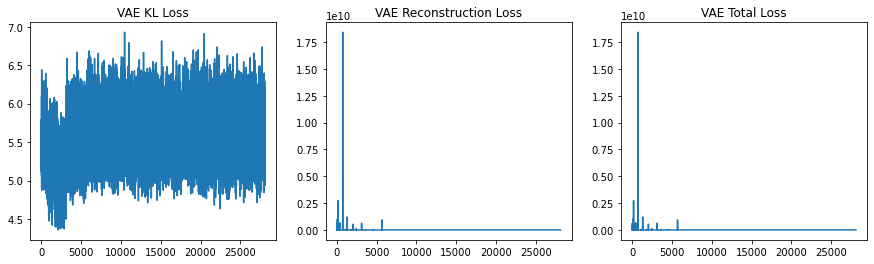

In [224]:
fig = plt.figure(figsize=(15, 4))
columns = 3
rows = 1
counter = 0
for losses, titles in zip([vae_losses_z2_KL, vae_losses_z2_re, vae_losses_z2],["VAE KL Loss","VAE Reconstruction Loss","VAE Total Loss"]):
    fig.add_subplot(rows, columns, counter+1)
    plt.plot(losses)
    plt.title(titles)
    counter += 1
plt.show()

### Save Checkpoint

In [6]:
filename = 'vae_model_z2.pth'

In [266]:
checkpoint = {
    'model_state_dict': vae_model_z2.state_dict(),
    'optimizer_state_dict': vae_optim_z2.state_dict(),
    'latent_width': vae_model_z2.latent_width,
    'epoch': 25,
    'losses': vae_losses_z2
}

with open(filename, 'wb') as f:
    pk.dump(checkpoint, f)

In [227]:
with open(filename, 'rb') as f:
    checkpoint_ = pk.load(f)

In [228]:
vae_model_z2 = VariationalAutoencoder(latent_width=checkpoint_['latent_width'])
vae_model_z2 = vae_model_z2.cuda()
vae_model_z2.load_state_dict(checkpoint_['model_state_dict'])

<All keys matched successfully>

### Plot some samples

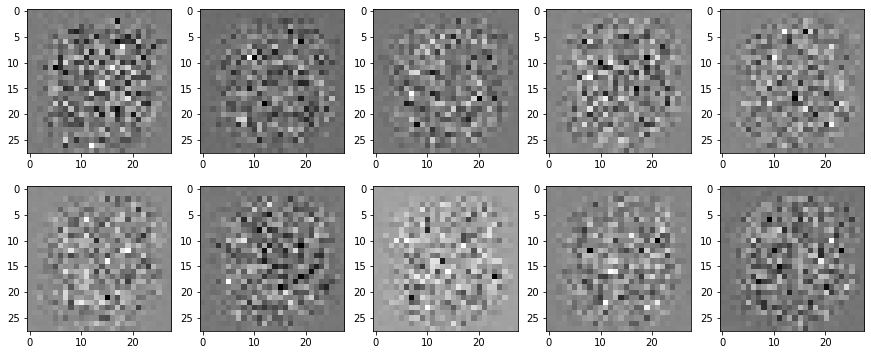

In [229]:
fig = plt.figure(figsize=(15, 6))
columns = 5
rows = 2
counter = 0
img_block = vae_model_z2.sample(10)
for img in img_block:
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    counter += 1
plt.show()

### Plot Latent Space output:

In [19]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    #norm = torch.distributions.normal.Normal(0, 1)
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            z = torch.Tensor(z).cuda()
            x_decoded = model.sample_given_z(z)
            digit = x_decoded[0].reshape([digit_size, digit_size])
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.cpu().detach().numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

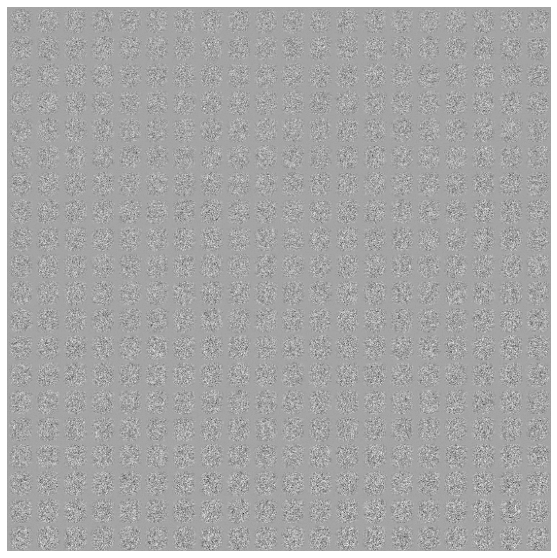

In [230]:
plot_latent_images(vae_model_z2, 20)

### Result:
The latent space is a bunch of noise blobs, but at least the borders of each supposed image are left blank

## (b) Plot the variance vector of the decoder for a single input as an image (in digit space;[3,28,28]). What is the interpretation of that? 

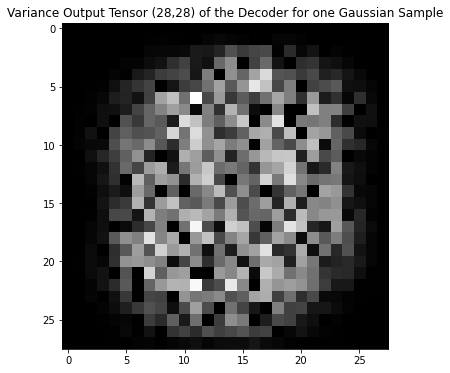

In [231]:
fig = plt.figure(figsize=(15, 6))

z = torch.empty((1, vae_model_z2.latent_width)).normal_(mean=0,std=1)
z = z.cuda()
y = vae_model_z2.decoder_start(z)
y = vae_model_z2.decoder(y.reshape([y.shape[0],32,7,7])) 
y = vae_model_z2.decoder_end(y.reshape([y.shape[0],-1]))
mean2, std2 = y[:,::2], y[:,1::2]
img_new = std2[0].detach().cpu().numpy() **2
plt.imshow(img_new.reshape((28,28)), cmap="gray")
plt.title("Variance Output Tensor (28,28) of the Decoder for one Gaussian Sample")
plt.show()

### Result:
The variance vector looks just like random noise in the center and 0 variance on the border

# Train with MSE instead of reconstruction loss, without decoder sampling
Exercise 2b) obviously doesnt work then anymore

In [7]:
def train_VAE_MSE(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
    """
    Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
    """
  
    use_test = False
    if isinstance(data, DataLoader):
        train_loader = data
    elif isinstance(data, tuple):
        if len(data) == 2:
            train_loader, test_loader = data
            if not isinstance(train_loader, DataLoader):
                raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
            if not isinstance(test_loader, DataLoader):
                raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
            use_test = True
        else:
            raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')

    #from here: https://discuss.pytorch.org/t/build-your-own-loss-function-in-pytorch/235
    #and here:https://discuss.pytorch.org/t/how-can-i-use-different-losses-to-update-different-branches-respectively-and-sum-grad-together-to-update-master-main-branch/21700/14
    loss_func_KL = KL_divergence_from_normal
    loss_func_mse = nn.MSELoss()
    
    model.train()
    losses = []
    losses_KL = []
    losses_mse = []
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            if cuda:
                x, y = x.cuda(), y.cuda()
            optimizer.zero_grad()
            output, mean, std = model.forward_without_decoder_sampling(x)
            
            loss1 = loss_func_KL(mean, std) 
            loss2 = loss_func_mse(output, x)

            loss = loss1 + loss2
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            losses_KL.append(loss1.item())
            losses_mse.append(loss2.item())

            if batch_idx % 50 == 0:
                print(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} KL Loss: {loss1.item():.6f}, MSE Loss: {loss2.item():.6f}, total Loss:{loss.item():.6f} |||||', end='\r')
                #sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} KL Loss: {loss1.item():.3f}, rec Loss: {loss2.item():.3f}, total Loss:{loss.item():.3f}')
    print()
    return losses_KL, losses_mse, losses

In [9]:
vae_model_mse = VariationalAutoencoder(latent_width=2)
vae_model_mse = vae_model_mse.cuda()
vae_optim_mse = optim.Adam(vae_model_mse.parameters(), lr=1e-4)
vae_losses_mse_KL, vae_losses_mse_re, vae_losses_mse = train_VAE_MSE(vae_model_mse, 
                                                                    vae_optim_mse, 
                                                                    (train_loader, test_loader), 
                                                                    max_epochs=10)

Epoch: 9/10 Step: 1850/1875 KL Loss: 0.000061, MSE Loss: 0.701923, total Loss:0.701984 |||||


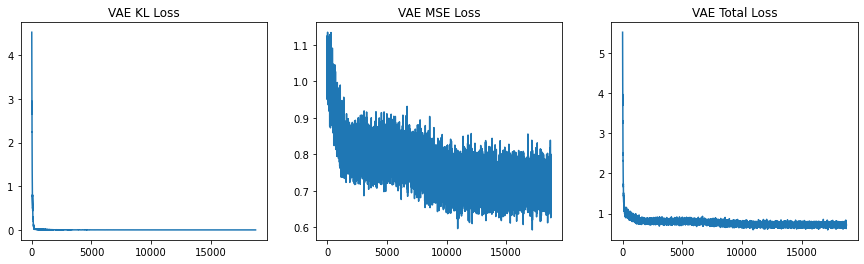

In [10]:
fig = plt.figure(figsize=(15, 4))
columns = 3
rows = 1
counter = 0
for losses, titles in zip([vae_losses_mse_KL, vae_losses_mse_re, vae_losses_mse],["VAE KL Loss","VAE MSE Loss","VAE Total Loss"]):
    fig.add_subplot(rows, columns, counter+1)
    plt.plot(losses)
    plt.title(titles)
    counter += 1
plt.show()

In [11]:
filename_mse = 'vae_model_mse.pth'

In [12]:
checkpoint_mse = {
    'model_state_dict': vae_model_mse.state_dict(),
    'optimizer_state_dict': vae_optim_mse.state_dict(),
    'latent_width': vae_model_mse.latent_width,
    'epoch': 25,
    'losses': vae_losses_mse
}

with open(filename_mse, 'wb') as f:
    pk.dump(checkpoint_mse, f)

In [13]:
with open(filename_mse, 'rb') as f:
    checkpoint_mse = pk.load(f)

In [14]:
vae_model_mse = VariationalAutoencoder(latent_width=checkpoint_mse['latent_width'])
vae_model_mse = vae_model_mse.cuda()
vae_model_mse.load_state_dict(checkpoint_mse['model_state_dict'])

<All keys matched successfully>

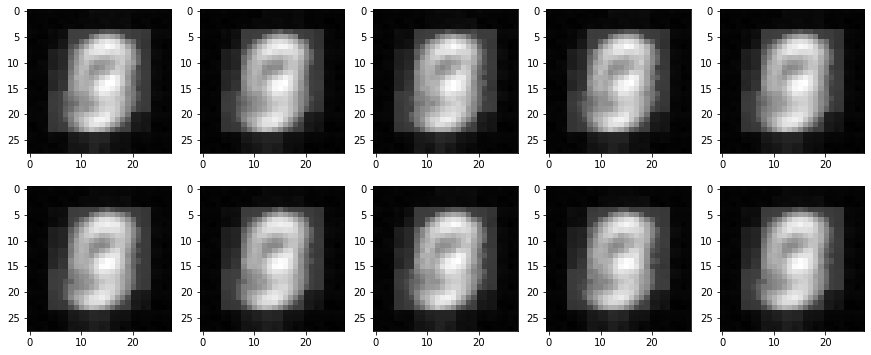

In [17]:
fig = plt.figure(figsize=(15, 6))
columns = 5
rows = 2
counter = 0
img_block = vae_model_mse.sample_without_decoder_sampling(10)
for img in img_block:
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    counter += 1
plt.show()

### Plot Latent Space output:

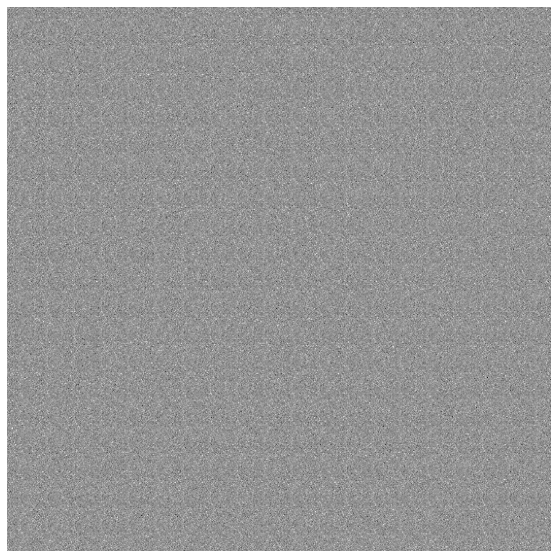

In [20]:
plot_latent_images(vae_model_mse, 20)

# Excercise 3. ”I’m not a robot”-Challenge
(a) Now imagine Google invents a new ”I’m not a robot”-game. This time it displays
numbers and you have to write them on a piece of white paper and scan them. Then
you need to upload your scan and Google verifies if you wrote down the right numbers.
Now you don’t have that much time in your life and on top of that you’re more the
lazy type. Unfortunately, the algorithm will recognize if you just use MNIST digits
and will think you are a robot, so you have to come up with a generative model from
which to sample the digits that you are asking for.
Think about a way of how to redefine your VAE architecture such that after training,
you can ask for a specific digit for sampling. You may want to look into Conditional
VAEs (CVAE) here. Implement a CVAE (or a model that achieves the same thing)
and sample the first 20 digits of π.

#### inspired by: https://github.com/timbmg/VAE-CVAE-MNIST

In [21]:
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot

In [22]:
class ConditionalVariationalAutoencoder(nn.Module):
    def __init__(self, latent_width, num_labels, cuda_flag=True):
        """
        The batch normalization has been removed, following advice from the tensorflow VAE introduction.
        The linear layer at the end of the encoder now gives double the latent width as outputs, being mu and sigma of a gaussian
        for each m im range(latent_width).
        The linear layer of the decoder still takes only once the latent width of inputs.
        """
        super(ConditionalVariationalAutoencoder, self).__init__()
        self.latent_width = latent_width
        self.num_labels = num_labels
        self.cuda_flag = cuda_flag
        encode = [nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
                  nn.LeakyReLU(),
                  nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
                  nn.LeakyReLU()]
        decode = [nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2, padding=0),
                  nn.LeakyReLU(),
                  nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2, padding=0),
                  nn.LeakyReLU()]
        self.encoder = nn.Sequential(*encode)
        self.encoder_end = nn.Linear(32 * 7 * 7, latent_width * 2)
        self.decoder_start = nn.Linear(latent_width + num_labels, 32 * 7 * 7)
        self.decoder = nn.Sequential(*decode)
        self.decoder_end = nn.Linear(1 * 28 * 28, 1 * 28 * 28 * 2)

    def forward(self, x, c):
        x = self.encoder(x)
        x = self.encoder_end(x.reshape([x.shape[0],-1]))
        mean, std = x[:,::2], x[:,1::2]
        z = self.reparameterize(mean, std)
        c = idx2onehot(c, n=10)
        z = torch.cat((z, c), dim=-1)
        y = self.decoder_start(z)
        y = self.decoder(y.reshape([y.shape[0],32,7,7]))
        y = self.decoder_end(y.reshape([y.shape[0],-1]))
        mean2, std2 = y[:,::2], y[:,1::2]
        y = torch.normal(mean=mean2, std=std2)
        y = y.reshape([y.shape[0], 1, 28, 28])
        return y, mean, std, mean2, std2
    
    def reparameterize(self, mu, std):
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

    def sample(self, batch_size, c):
        z = torch.empty((batch_size, self.latent_width)).normal_(mean=0,std=1)
        if self.cuda_flag:
            z = z.cuda()
        c = idx2onehot(c, n=10)
        z = torch.cat((z, c), dim=-1)
        y = self.decoder_start(z)
        y = self.decoder(y.reshape([y.shape[0],32,7,7]))
        y = self.decoder_end(y.reshape([y.shape[0],-1]))
        mean2, std2 = y[:,::2], y[:,1::2]
        y = torch.normal(mean=mean2, std=std2)
        y = y.reshape([y.shape[0], 1, 28, 28])
        return y
    
    def sample_given_z(self, z, c):
        c = idx2onehot(c, n=10)
        z = torch.cat((z, c), dim=-1)
        y = self.decoder_start(z)
        y = self.decoder(y.reshape([y.shape[0],32,7,7]))
        y = self.decoder_end(y.reshape([y.shape[0],-1]))
        mean2, std2 = y[:,::2], y[:,1::2]
        y = torch.normal(mean=mean2, std=std2)
        y = y.reshape([y.shape[0], 1, 28, 28])
        return y

In [23]:
def train_CVAE(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
    """
    Train a NN 'model' on 'data' in 'max_epochs' many epochs using 'optimizer' optimization method.
    """
  
    use_test = False
    if isinstance(data, DataLoader):
        train_loader = data
    elif isinstance(data, tuple):
        if len(data) == 2:
            train_loader, test_loader = data
            if not isinstance(train_loader, DataLoader):
                raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
            if not isinstance(test_loader, DataLoader):
                raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
            use_test = True
        else:
            raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')

    #from here: https://discuss.pytorch.org/t/build-your-own-loss-function-in-pytorch/235
    #and here:https://discuss.pytorch.org/t/how-can-i-use-different-losses-to-update-different-branches-respectively-and-sum-grad-together-to-update-master-main-branch/21700/14
    loss_func_KL = KL_divergence_from_normal
    loss_func_rec = reconstruction_loss
    
    model.train()
    losses = []
    losses_KL = []
    losses_rec = []
    batch_total = len(train_loader)

    for epoch in range(max_epochs):
        samples_total = 0
        samples_correct = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch
            if cuda:
                x, y = x.cuda(), y.cuda()
            #optimizer.zero_grad()
            output, mean, std, mean2, std2 = model(x, y)
            
            loss1 = loss_func_KL(mean, std) 
            loss2 = loss_func_rec(x.reshape([x.shape[0],-1]), mean2, std2)

            loss = loss1 + loss2
            #loss = criterion(output, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            losses_KL.append(loss1.item())
            losses_rec.append(loss2.item())

            if batch_idx % 50 == 0:
                print(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} KL Loss: {loss1.item():.3f}, rec Loss: {loss2.item():.3f}, total Loss:{loss.item():.3f} |||||', end='\r')
                #sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Step: {batch_idx}/{batch_total} KL Loss: {loss1.item():.3f}, rec Loss: {loss2.item():.3f}, total Loss:{loss.item():.3f}')
    print()
    return losses_KL, losses_rec, losses

In [24]:
cvae_model = ConditionalVariationalAutoencoder(latent_width=256, num_labels=10)
cvae_model = cvae_model.cuda()
cvae_optim = optim.Adam(cvae_model.parameters(), lr=1e-4)
cvae_losses_KL, cvae_losses_re, cvae_losses = train_CVAE(cvae_model, 
                                                        cvae_optim, 
                                                        (train_loader, test_loader), 
                                                        max_epochs=10)

Epoch: 9/10 Step: 1850/1875 KL Loss: 541.581, rec Loss: 4471.862, total Loss:5013.442 |||||||| |||||


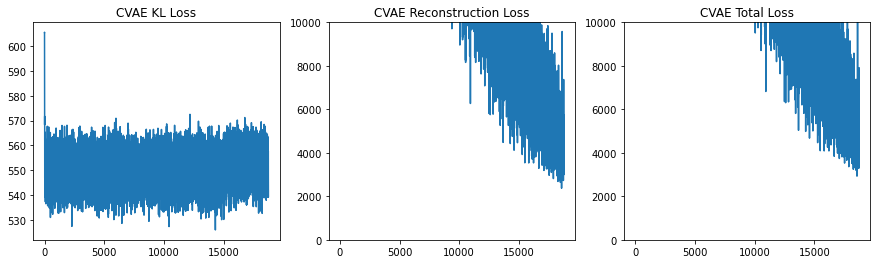

In [25]:
fig = plt.figure(figsize=(15, 4))
columns = 3
rows = 1
counter = 0
for losses, titles in zip([cvae_losses_KL, cvae_losses_re, cvae_losses],["CVAE KL Loss","CVAE Reconstruction Loss","CVAE Total Loss"]):
    fig.add_subplot(rows, columns, counter+1)
    plt.plot(losses)
    plt.title(titles)
    if counter != 0:
        plt.ylim([0,10000])
    counter += 1
plt.show()

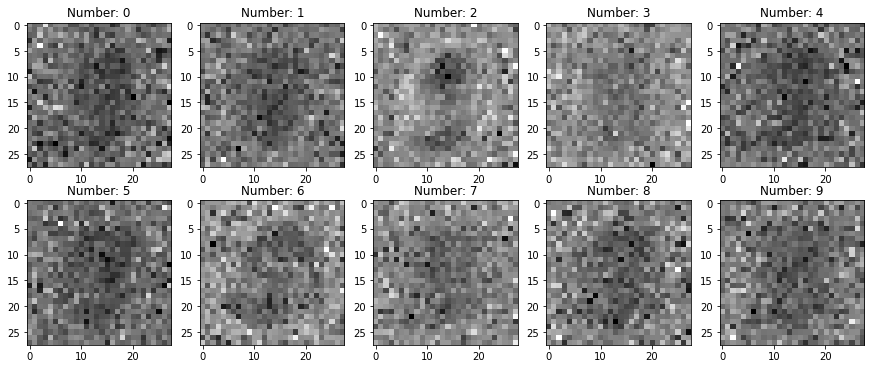

In [26]:
fig = plt.figure(figsize=(15, 6))
columns = 5
rows = 2
counter = 0
img_block = cvae_model.sample(10, torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).cuda())
for img in img_block:
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    plt.title("Number: {}".format(counter))
    counter += 1
plt.show()

In [108]:
filename_cvae = 'cvae_model.pth'

In [109]:
checkpoint_cvae = {
    'model_state_dict': cvae_model.state_dict(),
    'optimizer_state_dict': cvae_optim.state_dict(),
    'latent_width': cvae_model.latent_width,
    'epoch': 25,
    'losses': cvae_losses
}

with open(filename_cvae, 'wb') as f:
    pk.dump(checkpoint_cvae, f)

In [110]:
with open(filename_cvae, 'rb') as f:
    checkpoint_cvae = pk.load(f)

In [111]:
cvae_model = VariationalAutoencoder(latent_width=checkpoint_cvae['latent_width'], num_labels=10)
cvae_model = cvae_model.cuda()
cvae_model.load_state_dict(checkpoint_cvae['model_state_dict'])

<All keys matched successfully>